# Основной код

## Данные

### Библиотеки

In [2]:
import boto3
import random
import os
import pandas as pd
from pymorphy2 import MorphAnalyzer
import pickle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pandarallel import pandarallel
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import nltk
import numpy as np
from tqdm import tqdm
import mlflow
from dvc.api import DVCFileSystem

from private import s3_access_key, s3_secret_key, mlflow_server_ip

tqdm.pandas()
nltk.download('stopwords')
pd.options.mode.chained_assignment = None
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 1 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/daniilrubin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Скачиваем предобработанные данные из dvc.
Перед запуском шага проверьте, что в файле .dvc/config лежат правильные авторизационные данные для s3

В результате в папке data будут файлы:
 - df_train.parquet
 - df_val.parquet
 - df_test.parquet
 - id2hub.pkl
 - tfidf_vectorizer.pkl
   
После выполнения этого шага можно переходить сразу к обучению моделей и не делать еще раз загрузку сырых данных и их препроцессинг. 

In [3]:
# downloading data from dvc
fs = DVCFileSystem()
fs.get('data', 'data', recursive=True)

### Скачиваем данные

In [2]:
s3_client = boto3.client(
    service_name='s3',
    endpoint_url='https://storage.yandexcloud.net',
    aws_access_key_id=s3_access_key,
    aws_secret_access_key=s3_secret_key
)

In [3]:
BUCKET = "habr-hse"
PATH = "datasets/2023/articles.pkl"

In [4]:
%%time

df_orig = pickle.loads(s3_client.get_object(Bucket=BUCKET, Key=PATH).get('Body').read())
len_df_orig = len(df_orig)
print(len_df_orig)
df_orig.head(5)

20000
CPU times: user 1.12 s, sys: 492 ms, total: 1.61 s
Wall time: 5.27 s


,id,title,text,time,hubs,tags
0,768040,«Сбер» перевёл свою банкоматную сеть на собств...,17 октября 2023 года «Сбер» сообщил о переводе...,17 окт в 14:36,Информационная безопасность *|Платежные систем...,сбер|банкомат|процессинг
1,768038,Code smells — обзор на примере PHP,"Hola, Amigos! Меня зовут Евгений Шмулевский, я...",17 окт в 14:27,PHP *|Программирование *|Совершенный код *,codesmell|php|разработка сайтов|код|программир...
2,768036,Беспарольный вход стал основным для пользовате...,VK ID обновил процесс авторизации пользователе...,17 окт в 14:25,Информационная безопасность *|Социальные сети ...,it-компании|vk id|пароли|вконтакте|соцсети
3,768034,Улучшенная маршрутизация HTTP-серверов в Go 1.22,В Go 1.22 ожидается появление интересного пред...,17 окт в 14:17,Go *,mux|роутинг
4,768032,Xiaomi представила собственную мобильную опера...,Xiaomi выпустит новую операционную систему под...,17 окт в 14:08,Разработка под Android *|Гаджеты |Смартфоны |И...,xiaomi|hyperos|операционные системы|ос|мобильн...


In [5]:
print('Максимум хабов:', df_orig['hubs'].apply(lambda text: len(text.replace('*', '').split('|'))).max())

Максимум хабов: 6


### Формируем качественные данные

In [6]:
df = df_orig.copy()
df['time'] = df['time']
df['tags'] = df['tags'].apply(lambda tags: tags.split('|'))
df['hubs'] = df['hubs'].apply(lambda hubs: hubs.replace('*', '').split('|'))
df_list = []
for i in tqdm(range(len(df))):
    df_i = df.iloc[[i]*len(df[i:i+1]['hubs'].values[0])]
    df_i['hubs'] = [label for label in df_i['hubs'].values[0]]
    df_list.append(df_i)
df = pd.concat(df_list)
print(len(df))
df.head(5)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:07<00:00, 2503.96it/s]


63367


,id,title,text,time,hubs,tags
0,768040,«Сбер» перевёл свою банкоматную сеть на собств...,17 октября 2023 года «Сбер» сообщил о переводе...,17 окт в 14:36,Информационная безопасность,"[сбер, банкомат, процессинг]"
0,768040,«Сбер» перевёл свою банкоматную сеть на собств...,17 октября 2023 года «Сбер» сообщил о переводе...,17 окт в 14:36,Платежные системы,"[сбер, банкомат, процессинг]"
0,768040,«Сбер» перевёл свою банкоматную сеть на собств...,17 октября 2023 года «Сбер» сообщил о переводе...,17 окт в 14:36,IT-инфраструктура,"[сбер, банкомат, процессинг]"
0,768040,«Сбер» перевёл свою банкоматную сеть на собств...,17 октября 2023 года «Сбер» сообщил о переводе...,17 окт в 14:36,Облачные сервисы,"[сбер, банкомат, процессинг]"
0,768040,«Сбер» перевёл свою банкоматную сеть на собств...,17 октября 2023 года «Сбер» сообщил о переводе...,17 окт в 14:36,Финансы в IT,"[сбер, банкомат, процессинг]"


In [7]:
df = df[~df['hubs'].str.contains('Блог компании')]

In [8]:
print(f'В среднем одна статья имеет: {len(df)/len_df_orig} категории')

В среднем одна статья имеет: 2.8193 категории


In [9]:
df['hubs'].value_counts()

hubs
IT-компании                     3324
Информационная безопасность     1782
Научно-популярное               1759
Искусственный интеллект         1690
Программирование                1415
                                ... 
Twitter API                        1
Google Web Toolkit                 1
Creative Commons                   1
Microsoft Access                   1
Silverlight                        1
Name: count, Length: 403, dtype: int64

In [10]:
min_count = 20
df_val_count = df['hubs'].value_counts()
true_hubs = df_val_count[df_val_count>=min_count].index
df = df[df['hubs'].apply(lambda hub: hub in true_hubs)]
df['hubs'].value_counts()

hubs
IT-компании                     3324
Информационная безопасность     1782
Научно-популярное               1759
Искусственный интеллект         1690
Программирование                1415
                                ... 
Монетизация IT-систем             20
Восстановление данных             20
WebAssembly                       20
Xcode                             20
Образование за рубежом            20
Name: count, Length: 260, dtype: int64

In [11]:
print(f"Всего уникальных категорий: {len(df['hubs'].unique())}")

Всего уникальных категорий: 260


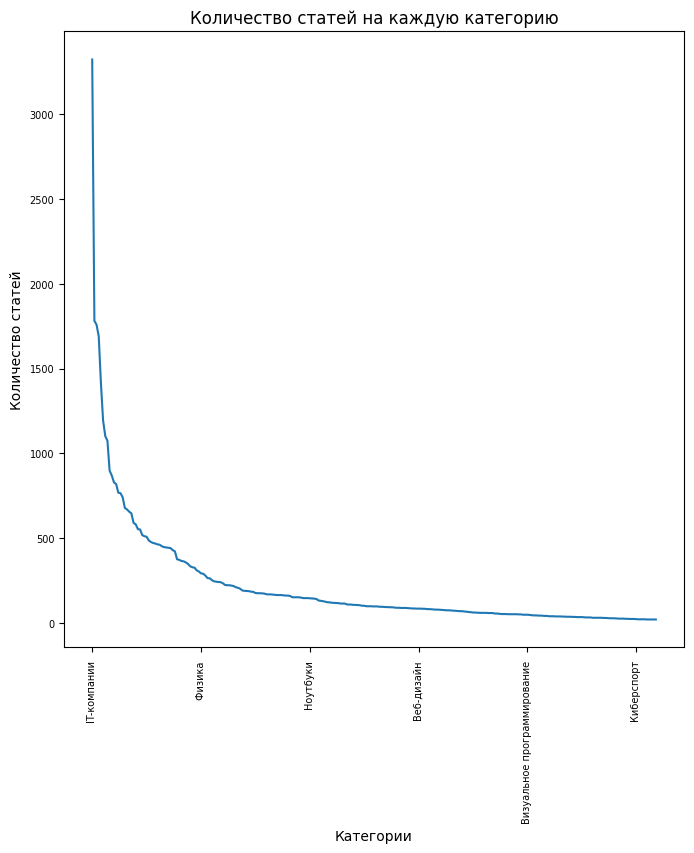

In [12]:
df['hubs'].value_counts().plot(figsize=(8, 8))
plt.xticks(rotation='vertical')
plt.title('Количество статей на каждую категорию')
plt.ylabel('Количество статей')
plt.xlabel('Категории')
plt.tick_params(labelsize = 7)
plt.show()

In [13]:
df['hubs'] = df['hubs'].apply(lambda hub: [hub.strip()])
df = df.groupby('id').agg({'title':'first', 'text':'first', 'time':'first', 'hubs':'sum', 'tags':'first'}).reset_index()
df

,id,title,text,time,hubs,tags
0,720724,Книга «Внутри CPYTHON: гид по интерпретатору P...,"Привет, Хаброжители!\n\nCPython, самая популя...",6 мар в 17:15,"[Python, Профессиональная литература]",[cpyrhon]
1,720726,Продуктовые и фиче-команды,Эта статья наверняка огорчит многих.Я сожалею ...,6 мар в 14:35,[Управление продуктом],"[управление продуктом, product manager, фиче-к..."
2,720730,Как устроен виртуальный помощник для data-серв...,"Привет! Меня зовут Александр, я главный систем...",6 мар в 14:39,"[Big Data, Хранилища данных]","[data governance, metadata, метаданные, управл..."
3,720732,Полный гайд по собеседованиям в IT,В прошлых статьях мы обсудили вход в IT и узна...,6 мар в 14:40,"[Учебный процесс в IT, Карьера в IT-индустрии]","[войти в айти, собеседования, подготовка, джун..."
4,720734,Зависимость вероятности увольнения сотрудников...,По ходу своей работы я давно сделал субъективн...,6 мар в 14:47,"[Управление проектами, Управление персоналом]","[управление людьми, управление проектами и ком..."
...,...,...,...,...,...,...
19701,768032,Xiaomi представила собственную мобильную опера...,Xiaomi выпустит новую операционную систему под...,17 окт в 14:08,"[Разработка под Android, Гаджеты, Смартфоны, И...","[xiaomi, hyperos, операционные системы, ос, мо..."
19702,768034,Улучшенная маршрутизация HTTP-серверов в Go 1.22,В Go 1.22 ожидается появление интересного пред...,17 окт в 14:17,[Go],"[mux, роутинг]"
19703,768036,Беспарольный вход стал основным для пользовате...,VK ID обновил процесс авторизации пользователе...,17 окт в 14:25,"[Информационная безопасность, Социальные сети ...","[it-компании, vk id, пароли, вконтакте, соцсети]"
19704,768038,Code smells — обзор на примере PHP,"Hola, Amigos! Меня зовут Евгений Шмулевский, я...",17 окт в 14:27,"[PHP, Программирование, Совершенный код]","[codesmell, php, разработка сайтов, код, прогр..."


In [14]:
df.to_parquet('data/df.parquet', index=False)

### Препроцессинг текста

In [16]:
df = pd.read_parquet('data/df.parquet')

In [17]:
# puncts = '.,"\'?!:;()[]{}<>-–‐—_/\\|*&%$€£¥₽#@^+=~`«»“”‘’0123456789'
# puncts = '.,"\'?!:;()[]{}<>-–‐—_/\\|*&%$€£¥₽#@^+=~`«»“”‘’'
# puncts = '.,"\'?!:()-–‐—`«»“”‘’'
puncts = ''
def del_puncts(text, puncts=puncts):
    return ''.join([symbol if symbol not in puncts else ' ' for symbol in text.replace('\t', ' ').replace('\n', ' ')])

In [18]:
%%time

df['clear_text'] = df['text'].parallel_apply(del_puncts)
df

CPU times: user 1.41 s, sys: 405 ms, total: 1.81 s
Wall time: 16 s


,id,title,text,time,hubs,tags,clear_text
0,720724,Книга «Внутри CPYTHON: гид по интерпретатору P...,"Привет, Хаброжители!\n\nCPython, самая популя...",6 мар в 17:15,"[Python, Профессиональная литература]",[cpyrhon],"Привет, Хаброжители! CPython, самая популярн..."
1,720726,Продуктовые и фиче-команды,Эта статья наверняка огорчит многих.Я сожалею ...,6 мар в 14:35,[Управление продуктом],"[управление продуктом, product manager, фиче-к...",Эта статья наверняка огорчит многих.Я сожалею ...
2,720730,Как устроен виртуальный помощник для data-серв...,"Привет! Меня зовут Александр, я главный систем...",6 мар в 14:39,"[Big Data, Хранилища данных]","[data governance, metadata, метаданные, управл...","Привет! Меня зовут Александр, я главный систем..."
3,720732,Полный гайд по собеседованиям в IT,В прошлых статьях мы обсудили вход в IT и узна...,6 мар в 14:40,"[Учебный процесс в IT, Карьера в IT-индустрии]","[войти в айти, собеседования, подготовка, джун...",В прошлых статьях мы обсудили вход в IT и узна...
4,720734,Зависимость вероятности увольнения сотрудников...,По ходу своей работы я давно сделал субъективн...,6 мар в 14:47,"[Управление проектами, Управление персоналом]","[управление людьми, управление проектами и ком...",По ходу своей работы я давно сделал субъективн...
...,...,...,...,...,...,...,...
19701,768032,Xiaomi представила собственную мобильную опера...,Xiaomi выпустит новую операционную систему под...,17 окт в 14:08,"[Разработка под Android, Гаджеты, Смартфоны, И...","[xiaomi, hyperos, операционные системы, ос, мо...",Xiaomi выпустит новую операционную систему под...
19702,768034,Улучшенная маршрутизация HTTP-серверов в Go 1.22,В Go 1.22 ожидается появление интересного пред...,17 окт в 14:17,[Go],"[mux, роутинг]",В Go 1.22 ожидается появление интересного пред...
19703,768036,Беспарольный вход стал основным для пользовате...,VK ID обновил процесс авторизации пользователе...,17 окт в 14:25,"[Информационная безопасность, Социальные сети ...","[it-компании, vk id, пароли, вконтакте, соцсети]",VK ID обновил процесс авторизации пользователе...
19704,768038,Code smells — обзор на примере PHP,"Hola, Amigos! Меня зовут Евгений Шмулевский, я...",17 окт в 14:27,"[PHP, Программирование, Совершенный код]","[codesmell, php, разработка сайтов, код, прогр...","Hola, Amigos! Меня зовут Евгений Шмулевский, я..."


In [19]:
morph = MorphAnalyzer()
morph.parse('ПоЗВонИ')[0].normal_form

'позвонить'

In [20]:
def get_tokens(text, morph=morph):
    return ' '.join([morph.parse(word)[0].normal_form for word in text.split() if word != ''])

In [21]:
%%time

df['tokens_text'] = df['clear_text'].parallel_apply(get_tokens)
df

CPU times: user 11.9 s, sys: 1.52 s, total: 13.5 s
Wall time: 1h 2min 38s


,id,title,text,time,hubs,tags,clear_text,tokens_text
0,720724,Книга «Внутри CPYTHON: гид по интерпретатору P...,"Привет, Хаброжители!\n\nCPython, самая популя...",6 мар в 17:15,"[Python, Профессиональная литература]",[cpyrhon],"Привет, Хаброжители! CPython, самая популярн...","привет, хаброжители! cpython, самый популярный..."
1,720726,Продуктовые и фиче-команды,Эта статья наверняка огорчит многих.Я сожалею ...,6 мар в 14:35,[Управление продуктом],"[управление продуктом, product manager, фиче-к...",Эта статья наверняка огорчит многих.Я сожалею ...,этот статья наверняка огорчить многих.ть сожал...
2,720730,Как устроен виртуальный помощник для data-серв...,"Привет! Меня зовут Александр, я главный систем...",6 мар в 14:39,"[Big Data, Хранилища данных]","[data governance, metadata, метаданные, управл...","Привет! Меня зовут Александр, я главный систем...","привет! я звать александр, я главный системный..."
3,720732,Полный гайд по собеседованиям в IT,В прошлых статьях мы обсудили вход в IT и узна...,6 мар в 14:40,"[Учебный процесс в IT, Карьера в IT-индустрии]","[войти в айти, собеседования, подготовка, джун...",В прошлых статьях мы обсудили вход в IT и узна...,в прошлый статья мы обсудить вход в it и узнал...
4,720734,Зависимость вероятности увольнения сотрудников...,По ходу своей работы я давно сделал субъективн...,6 мар в 14:47,"[Управление проектами, Управление персоналом]","[управление людьми, управление проектами и ком...",По ходу своей работы я давно сделал субъективн...,по ход свой работа я давно сделать субъективны...
...,...,...,...,...,...,...,...,...
19701,768032,Xiaomi представила собственную мобильную опера...,Xiaomi выпустит новую операционную систему под...,17 окт в 14:08,"[Разработка под Android, Гаджеты, Смартфоны, И...","[xiaomi, hyperos, операционные системы, ос, мо...",Xiaomi выпустит новую операционную систему под...,xiaomi выпустить новый операционный система по...
19702,768034,Улучшенная маршрутизация HTTP-серверов в Go 1.22,В Go 1.22 ожидается появление интересного пред...,17 окт в 14:17,[Go],"[mux, роутинг]",В Go 1.22 ожидается появление интересного пред...,в go 1.22 ожидаться появление интересный предл...
19703,768036,Беспарольный вход стал основным для пользовате...,VK ID обновил процесс авторизации пользователе...,17 окт в 14:25,"[Информационная безопасность, Социальные сети ...","[it-компании, vk id, пароли, вконтакте, соцсети]",VK ID обновил процесс авторизации пользователе...,vk id обновить процесс авторизация пользовател...
19704,768038,Code smells — обзор на примере PHP,"Hola, Amigos! Меня зовут Евгений Шмулевский, я...",17 окт в 14:27,"[PHP, Программирование, Совершенный код]","[codesmell, php, разработка сайтов, код, прогр...","Hola, Amigos! Меня зовут Евгений Шмулевский, я...","hola, amigos! я звать евгений шмулевский, я ph..."


In [22]:
df.to_parquet('data/df.parquet', index=False)

### Train-test split

In [23]:
df = pd.read_parquet('data/df.parquet')

In [24]:
df_train, df_val_test = train_test_split(df,
                                         test_size=0.2,
                                         random_state=42)
df_val, df_test = train_test_split(df_val_test,
                                   test_size=0.5,
                                   random_state=42)

In [25]:
df_train.to_parquet('data/df_train.parquet', index=False)
df_val.to_parquet('data/df_val.parquet', index=False)
df_test.to_parquet('data/df_test.parquet', index=False)

### MLFlow

In [6]:
mlflow.set_tracking_uri(f'http://{mlflow_server_ip}:1234')

## Метрики

Количество угаданных хабов

In [7]:
def intersection_hubs(true_hubs, pred_hubs):
    intersection = 0
    for hub in true_hubs:
        if hub in pred_hubs:
            intersection += 1
    return intersection

Доля угаданных хабов из топ-k предсказанных

In [8]:
def precision_hubs(true_hubs, pred_hubs):
    intersection = intersection_hubs(true_hubs, pred_hubs)
    precision = intersection / len(pred_hubs)
    return precision

Доля угаданных хабов из возможных

In [9]:
def recall_hubs(true_hubs, pred_hubs):
    len_true_hubs = len(true_hubs)
    if len_true_hubs == 0:
        recall = 1
    else:
        intersection = intersection_hubs(true_hubs, pred_hubs)
        recall = intersection / len_true_hubs
    return recall

Геометрическое среднее двух метрик выше

In [10]:
def f1_score(precision, recall):
    pr_plus_rec = precision + recall
    if pr_plus_rec == 0:
        f1 = 0
    else:
        f1 = 2*precision*recall/pr_plus_rec
    return f1

## Baseline Const

In [ ]:
baseline_const_exp = 'baseline_const'
run_name = 'const'

mlflow.set_experiment(baseline_const_exp)

In [ ]:
df_train = pd.read_parquet('data/df_train.parquet')
df_test = pd.read_parquet('data/df_test.parquet')

In [ ]:
K = 5

In [ ]:
top_k_hubs = pd.Series([i for j in df_train['hubs'].values for i in j]).value_counts().index[:K]
top_k_hubs

In [17]:
df_test['pred_hubs_base'] = [top_k_hubs.copy() for _ in range(len(df_test))]
df_test['precision_base'] = df_test.apply(lambda row: precision_hubs(row['hubs'], row['pred_hubs_base']), axis=1)
df_test['recall_base'] = df_test.apply(lambda row: recall_hubs(row['hubs'], row['pred_hubs_base']), axis=1)
df_test['f1_base'] = df_test.apply(lambda row: f1_score(row['precision_base'], row['recall_base']), axis=1)
precision_baseline = round(df_test['precision_base'].mean(), 6)
recall_baseline = round(df_test['recall_base'].mean(), 6)
f1_baseline = round(df_test['f1_base'].mean(), 6)

In [19]:
metrics = {
    'precision': precision_baseline,
    'recall': recall_baseline,
    'f1': f1_baseline,
}

with mlflow.start_run(run_name=run_name):
    mlflow.log_param('K', K)
    mlflow.log_metrics(metrics)

In [20]:
print('Метрики baseline решения:')
print(f'Precision@{K} - {precision_baseline}')
print(f'Recall@{K} - {recall_baseline}')
print(f'F1@{K} - {f1_baseline}')

Метрики baseline решения:
Precision@5 - 0.105429
Recall@5 - 0.191646
F1@5 - 0.130867


In [21]:
df_test.to_csv('data/df_test.csv', index=False)

## Обучение модели

### TF-IDF векторизация

In [43]:
df_train = pd.read_parquet('data/df_train.parquet')
df_val = pd.read_parquet('data/df_val.parquet')

In [44]:
%%time

stop_words = nltk.corpus.stopwords.words("russian")
tfidf_vectorizer = TfidfVectorizer(analyzer='word', min_df=10, stop_words=stop_words)
df_train['tfidf_vec'] = [i for i in tfidf_vectorizer.fit_transform(df_train['tokens_text'].values).toarray()]
df_val['tfidf_vec'] = [i for i in tfidf_vectorizer.transform(df_val['tokens_text'].values).toarray()]
size_vector = len(df_train['tfidf_vec'].values[0])
print(f'Размер tf-idf вектора: {size_vector}')

Размер tf-idf вектора: 47751
CPU times: user 14.9 s, sys: 3.23 s, total: 18.2 s
Wall time: 18.7 s


In [45]:
with open('data/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

### Neural Network

Dataset

In [46]:
count_hubs = pd.Series([i for j in df_train['hubs'].values for i in j]).value_counts()
all_hubs = count_hubs.index
hub2id = dict(zip(all_hubs, range(len(all_hubs))))
id2hub = {j: i for i, j in hub2id.items()}
num_hubs = len(hub2id)
print(f'Предлагаем из {num_hubs} хабов')

Предлагаем из 260 хабов


In [47]:
def transform_target(hubs):
    vector = np.zeros(num_hubs)
    for hub in hubs:
        vector[hub] = 1
    return vector

In [48]:
class Dataset_hubs(Dataset):
    def __init__(self, df):
        self.vecs = df['tfidf_vec'].values
        self.hubs = df['hubs'].apply(lambda hubs: transform_target([hub2id[hub] for hub in hubs if hub in hub2id])).values
        
    def __getitem__(self, index):
        return self.vecs[index], self.hubs[index]

    def __len__(self):
        return len(self.vecs)

In [49]:
train_data = Dataset_hubs(df_train)
val_data = Dataset_hubs(df_val)

DataLoader

In [50]:
batch_size = 2048
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)

Метрики

In [51]:
K = 5

Доля угаданных хабов из топ-k предсказанных

In [52]:
def precision_vectors(y_true, y_pred):
    intersection = y_true@y_pred
    precision = intersection / sum(y_pred)
    return precision

Доля угаданных хабов из возможных

In [53]:
def recall_vectors(y_true, y_pred):
    num_true_hubs = sum(y_true == 1)
    if num_true_hubs == 0:
        recall = 1
    else:
        intersection = y_true@y_pred
        recall = intersection / num_true_hubs
    return recall

Геометрическое среднее двух метрик выше

In [54]:
def f1_score(precision, recall):
    pr_plus_rec = precision + recall
    if pr_plus_rec == 0:
        f1 = 0
    else:
        f1 = 2*precision*recall/pr_plus_rec
    return f1

Модель

In [55]:
class Model_hubs(nn.Module):
    def __init__(self, size_in, size_hide, size_out):
        super().__init__()
        self.linear_1 = nn.Linear(size_in, size_hide)
        self.bn = nn.BatchNorm1d(size_hide)
        self.tanh = nn.Tanh()
        self.dp = nn.Dropout(0.8)
        self.linear_2 = nn.Linear(size_hide, size_out)
        
    def forward(self, x):
        x = x.to(torch.float32)
        x = self.linear_1(x)
        x = self.bn(x)
        x = self.tanh(x)
        x = self.dp(x)
        x = self.linear_2(x)
        return x

    def predict(self, text, del_puncts, get_tokens, tfidf_vectorizer, id2hub, k=5, device='cpu'):
        clear_text = del_puncts(text)
        tokens_text = get_tokens(clear_text)
        tfidf_vector = tfidf_vectorizer.transform([tokens_text]).toarray()[0]
        output = self.forward(torch.tensor(np.array([tfidf_vector])).to(device)).detach().cpu().numpy()[0]
        preds = np.argsort(output)[::-1][:k]
        scores = output[preds]
        hubs = [id2hub[id_hub] for id_hub in preds]
        return list(zip(hubs, scores))

Фиксация seed

In [56]:
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)

Обучение

In [57]:
mvp_model_exp = 'mvp'
run_name = 'basic'

mlflow.set_experiment(mvp_model_exp)

mlflow.start_run(run_name=run_name)

<ActiveRun: >

In [58]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

mlflow.log_param('device', device)

'cpu'

In [59]:
size_vector = len(df_train['tfidf_vec'].values[0])
print(f'Размер tf-idf вектора: {size_vector}')

mlflow.log_param('vectorizer', 'TfidfVectorizer')

Размер tf-idf вектора: 47751


'TfidfVectorizer'

In [60]:
set_seed(42)
model = Model_hubs(size_in=size_vector, 
                   size_hide=1_000,
                   size_out=num_hubs).to(device)
mlflow.log_param('dropout', 0.8)
mlflow.log_param('size_hide', 1000)

model.train()

Model_hubs(
  (linear_1): Linear(in_features=47751, out_features=1000, bias=True)
  (bn): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tanh): Tanh()
  (dp): Dropout(p=0.8, inplace=False)
  (linear_2): Linear(in_features=1000, out_features=260, bias=True)
)

In [61]:
num_params = sum([param.nelement() for param in model.parameters()])
print(f'Количество обучаемых параметров: {num_params}')

Количество обучаемых параметров: 48014260


In [62]:
balance_hubs = count_hubs.values.max() / count_hubs.values

In [63]:
set_seed(42)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor(balance_hubs).float().to(device))

In [ ]:
%%time

epochs = 20

set_seed(42)

for epoch_num in range(epochs):
    
    train_loss = 0
    train_pr = 0
    train_rec = 0
    train_f1 = 0
    val_loss = 0
    val_pr = 0
    val_rec = 0
    val_f1 = 0
    
    model.train()
    for data, hubs in tqdm(train_loader):
        data = data.to(device)
        hubs = hubs.to(device)
        output = model(data)
        loss = criterion(output, hubs)
        train_loss += loss.item()
        output = output.detach().cpu().numpy()
        hubs = hubs.detach().cpu().numpy()
        for i in range(len(output)):
            output_i = output[i]
            hubs_i = hubs[i]
            preds = transform_target(np.argsort(output_i)[::-1][:K])
            pr = precision_vectors(hubs_i, preds)
            rec = recall_vectors(hubs_i, preds)
            f1 = f1_score(pr, rec)
            train_pr += pr
            train_rec += rec
            train_f1 += f1
        model.zero_grad()
        loss.backward()
        optimizer.step()
        
    model.eval()
    for data, hubs in tqdm(val_loader):
        data = data.to(device)
        hubs = hubs.to(device)
        output = model(data)
        loss = criterion(output, hubs)
        val_loss += loss.item()
        output = output.detach().cpu().numpy()
        hubs = hubs.detach().cpu().numpy()
        for i in range(len(output)):
            output_i = output[i]
            hubs_i = hubs[i]
            preds = transform_target(np.argsort(output_i)[::-1][:K])
            pr = precision_vectors(hubs_i, preds)
            rec = recall_vectors(hubs_i, preds)
            f1 = f1_score(pr, rec)
            val_pr += pr
            val_rec += rec
            val_f1 += f1
        
    train_loss = round(train_loss / len(train_data), 6)
    train_pr = round(train_pr / len(train_data), 6)
    train_rec = round(train_rec / len(train_data), 6)
    train_f1 = round(train_f1 / len(train_data), 6)
    val_loss = round(val_loss / len(val_data), 6)
    val_pr = round(val_pr / len(val_data), 6)
    val_rec = round(val_rec / len(val_data), 6)
    val_f1 = round(val_f1 / len(val_data), 6)
    
    
    print(
        f"Epochs: {epoch_num + 1} | Train Loss: {train_loss} \
        | Train Precision: {train_pr} | Train Recall: {train_rec} | Train F1: {train_f1} \
        " + "\n" + " "*len(str(epoch_num + 1)) +
f"         | Val Loss: {val_loss}   \
        | Val Precision: {val_pr}   | Val Recall: {val_rec}   | Val F1: {val_f1}")

  0%|                                                                                                                                                 | 0/8 [00:00<?, ?it/s]

In [33]:
torch.save(model, "data/model.pth")

In [34]:
with open('data/id2hub.pkl', 'wb') as f:
    pickle.dump(id2hub, f)

## Тест модели

In [35]:
model = torch.load('data/model.pth')
df_train = pd.read_parquet('data/df_train.parquet')
df_val = pd.read_parquet('data/df_val.parquet')
df_test = pd.read_parquet('data/df_test.parquet')
df_train['hubs'] = df_train['hubs'].apply(eval)
df_val['hubs'] = df_val['hubs'].apply(eval)
df_test['hubs'] = df_test['hubs'].apply(eval)
df_train['tags'] = df_train['tags'].apply(eval)
df_val['tags'] = df_val['tags'].apply(eval)
df_test['tags'] = df_test['tags'].apply(eval)
with open('data/tfidf_vectorizer.pkl', 'rb') as f:
    tfidf_vectorizer = pickle.load(f)
with open('data/id2hub.pkl', 'rb') as f:
    id2hub = pickle.load(f)

In [36]:
# puncts = '.,"\'?!:;()[]{}<>-–‐—_/\\|*&%$€£¥₽#@^+=~`«»“”‘’0123456789'
# puncts = '.,"\'?!:;()[]{}<>-–‐—_/\\|*&%$€£¥₽#@^+=~`«»“”‘’'
# puncts = '.,"\'?!:()-–‐—`«»“”‘’'
puncts = ''
def del_puncts(text, puncts=puncts):
    return ''.join([symbol if symbol not in puncts else ' ' for symbol in text.replace('\t', ' ').replace('\n', ' ')])

In [37]:
morph = MorphAnalyzer()
def get_tokens(text, morph=morph):
    return ' '.join([morph.parse(word)[0].normal_form for word in text.split() if word != ''])

In [38]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [39]:
K=5

До этого метрики считались только по num_hubs предсказываемым хабам

Фактические метрики на тестовой выборке:

In [40]:
df_test['pred_hubs_nn'] = df_test['text'].progress_apply(lambda text: model.predict(text, 
                                                                               del_puncts, 
                                                                               get_tokens, 
                                                                               tfidf_vectorizer, 
                                                                               id2hub, 
                                                                               K, 
                                                                               device))
df_test['pred_scores_nn'] = df_test['pred_hubs_nn'].apply(lambda hubs_scores: [hub_score[1] for hub_score in hubs_scores])
df_test['pred_hubs_nn'] = df_test['pred_hubs_nn'].apply(lambda hubs_scores: [hub_score[0] for hub_score in hubs_scores])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1971/1971 [06:44<00:00,  4.88it/s]


In [41]:
df_test['precision_nn'] = df_test.apply(lambda row: precision_hubs(row['hubs'], row['pred_hubs_nn']), axis=1)
df_test['recall_nn'] = df_test.apply(lambda row: recall_hubs(row['hubs'], row['pred_hubs_nn']), axis=1)
df_test['f1_nn'] = df_test.apply(lambda row: f1_score(row['precision_nn'], row['recall_nn']), axis=1)
precision_baseline = round(df_test['precision_nn'].mean(), 6)
recall_baseline = round(df_test['recall_nn'].mean(), 6)
f1_baseline = round(df_test['f1_nn'].mean(), 6)

In [42]:
metrics = {
    'precision': precision_baseline,
    'recall': recall_baseline,
    'f1': f1_baseline,
}

mlflow.log_metrics(metrics)
mlflow.end_run()

In [42]:
print('Метрики Neural Network решения:')
print(f'Precision@{K} - {precision_baseline}')
print(f'Recall@{K} - {recall_baseline}')
print(f'F1@{K} - {f1_baseline}')

Метрики Neural Network решения:
Precision@5 - 0.401015
Recall@5 - 0.745789
F1@5 - 0.500357


In [43]:
df_test.to_csv('data/df_test.csv', index=False)

Случайный пример

In [68]:
i_test = 1
test_i = df_test[['text', 'hubs']].values[i_test]
test_text_i = test_i[0]
test_hubs_i = test_i[1]
print(test_text_i)
print(test_hubs_i)

Частная космическая компания Relativity Space планирует отказаться от использования напечатанной на 3D-принтере ракеты Terran 1 спустя несколько недель после первых испытаний носителя. Производитель намерен сосредоточиться на запусках более крупной ракеты Terran R в надежде удовлетворить потребности рынка и успешнее конкурировать с лидером отрасли — SpaceX.Relativity впервые запустила Terran 1 22 марта, однако ракета не смогла достичь орбиты из-за отказа двигателя. Переход на использование Terran R означает, что компания не будет проводить дополнительные старты до 2026 года, пока ракета не будет готова к полёту.Главный исполнительный директор Relativity Тим Эллис назвал это решение «очевидным выбором», поскольку запуски больших грузов сейчас пользуются повышенным спросом. Он считает, что «на рынке просто нет хороших решений».Компания сообщила о разработке Terran R в 2021 году. По словам Эллиса, большинство клиентов Relativity оказались довольны изменением направления, они согласились п

In [69]:
model.predict(test_text_i, del_puncts, get_tokens, tfidf_vectorizer, id2hub, K, device)

[('Космонавтика', 8.316977),
 ('3D-принтеры', 6.516875),
 ('Научно-популярное', 5.417019),
 ('Будущее здесь', 4.4825034),
 ('Астрономия', 4.4024477)]